# Convolutional Neural Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import random
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

## A note on GPUs

The models we create in this notebook are fairly small by CNN standards and should run on your computer.

For any reasonably sized problem, you should ensure you have GPU acceleration (such as installing tensorflow-macos / tensorflow-metal on a Mac).

## Working with Images in Python

Before we dive into CNNs themselves, we should first learn a bit about how images are represented digitally.

The `matplotlib.pyplot` module has several functions we can use to work with images in Python: [imread](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.pyplot.imread.html), [imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html), and [imsave](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imsave.html).

Let's begin by loading an example image using `imread` and displaying it with `imshow`.

#### Images as Tensors


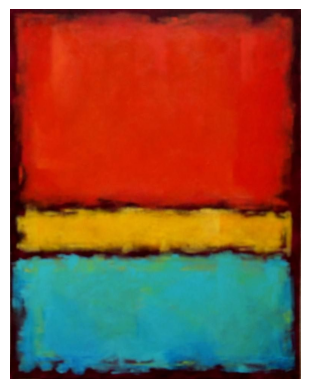

In [2]:
img = plt.imread("figs/rothko.jpg")
plt.axis("off")
plt.imshow(img)
plt.show()

What more can we learn about this `img` object that we created by reading in our image file?

In [3]:
print("Image Type:", type(img))
print("Image Shape:", img.shape)
print("Array Type:", img.dtype)
print(f"Value Range: [{img.min()}, {img.max()}]")

Image Type: <class 'numpy.ndarray'>
Image Shape: (981, 770, 3)
Array Type: uint8
Value Range: [0, 238]


The image is represented as a 3-dimensional numpy array, or **tensor**. The 1st dimension is height, the 2nd is width, and the 3rd is the **color channel**.

Each element, or pixel, in the array is an 8-bit, unsigned integer. $2^8 = 256$ so a pixel can take on values from 0 and 255. <br />
Because the images a numpy array we can use familiar Python indexing to specify certain sections.<br>
Let's explore the image's color channels. 

**Note:** Some image formats such as png can have a 4th channel referred to as **alpha** which controls transparency. `imshow` knows how to handle these 4-channel images, but it is important to keep this in mind lest the extra channel catch you by surprise.

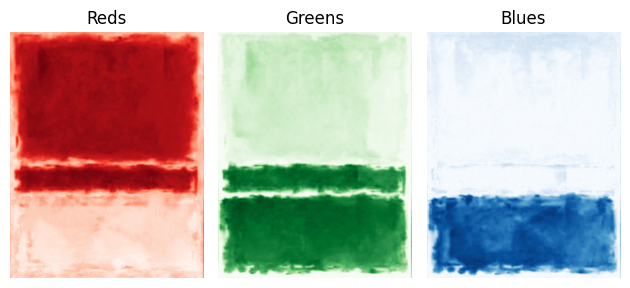

In [4]:
fig, axs = plt.subplots(1, 3)
rgb_list = ["Reds", "Greens", "Blues"]
for i, ax in enumerate(axs.ravel()):
    ax.imshow(img[:, :, i], cmap=rgb_list[i])
    ax.axis("off")
    ax.set_title(rgb_list[i])
    plt.tight_layout()

#### An Image from Scratch

We can use what we now know about an image's digital representation to build an image from scratch by creating and manipulating a `numpy` array.

Let's create a 5x5 RGB image made from scratch using `numpy` and call it `toy_img`.

To keep it simple, all pixels in each channel will be either fully on or off<br>
We'll use `1` for all the 'on' pixels and `0` for 'off' pixels.<br>

* `np.zeros()` can create an image of all 'off' pixels; we can then 'turn some on' using slicing/indexing
* `np.eye(N)` creates an identity NxN matrix 
* `np.flipud(a)` flips the array `a` upsidedown

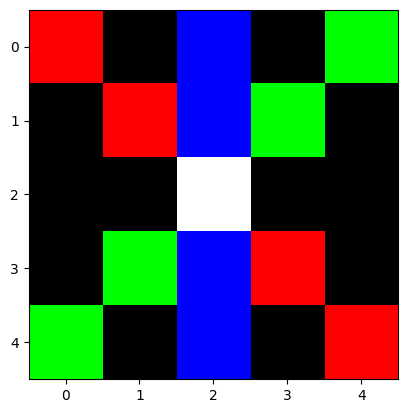

In [5]:
toy_img = np.zeros((5, 5, 3))  # blank image of all 'off' pixels
# RED
toy_img[:, :, 0] = np.eye(5)  # diagonal of red
# GREEN
toy_img[:, :, 1] = np.flipud(np.eye(5))  # backwards diagonal of green
# BLUE
toy_img[:, 2, 2] = 1  # vertical line of blue in the middle
plt.imshow(toy_img)
plt.show()

## Tensorflow Datasets

TensorFlow Datasets (TFDS) is a collection of datasets ready to use, with TensorFlow or other Python ML frameworks. These datasets are exposed as `tf.data.Dataset` objects, enabling easy-to-use and high-performance input pipelines.

To improve TensorFlow's performance in our current environment we can run the following commands. Don't worry too much over what all these commands are doing. There are links in the comments if you'd like to learn more.

In [6]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs
tf.compat.v1.enable_eager_execution()

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/datac_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Ensure replicable results
SEED = 42
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Loading Datasets

TFDS gives us access to dozens of research quality datasets with the simple `tfds.load` method.

An extensive catalogue of datasets can be seen <a href='https://www.tensorflow.org/datasets/catalog/overview'>here</a>.

One of the most bizzare datasets is <a href='http://laurencemoroney.com/horses-or-humans-dataset'>Horses or Humans</a>.

Our call to `tfds.load` will use several arguments:
- `name`: (str) the dataset to load (you can look these up in the above catalogue)
- `split`: (list) some datasets have pre-specified splits; this list defines which splits to load
- `shuffle_files`: (bool) files are loaded in random order
- `as_supervised`: (bool) loads labels if dataset has them
- `with_info`: (bool) also returns an DatasetInfo object with details about the loaded dataset

In [7]:
(ds_train, ds_test), ds_info = tfds.load(
    name="horses_or_humans",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

#### The Dataset Object

We'll be working with closely with the `tf.data.Dataset` object so we should learn more about its methods and structure.

Each element in the iterator is of type <class 'tuple'> with length 2


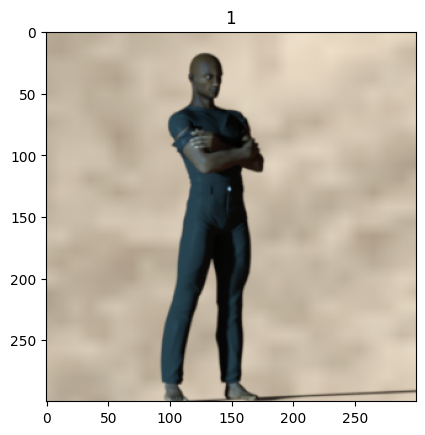

In [8]:
# create iterator from iterable
my_iter = iter(ds_train)
my_iter

# get next element from iterator
next_one = next(my_iter)
print(
    f"Each element in the iterator is of type {type(next_one)} with length {len(next_one)}"
)

# display element from iterator
image, label = next_one
plt.imshow(image)
plt.title(int(label))
plt.show()

It appears humans are the positive class. Let's make a dictionary to map class labels to strings.

In [9]:
# create human interperatable class names
class_names = {0: "horse", 1: "human"}

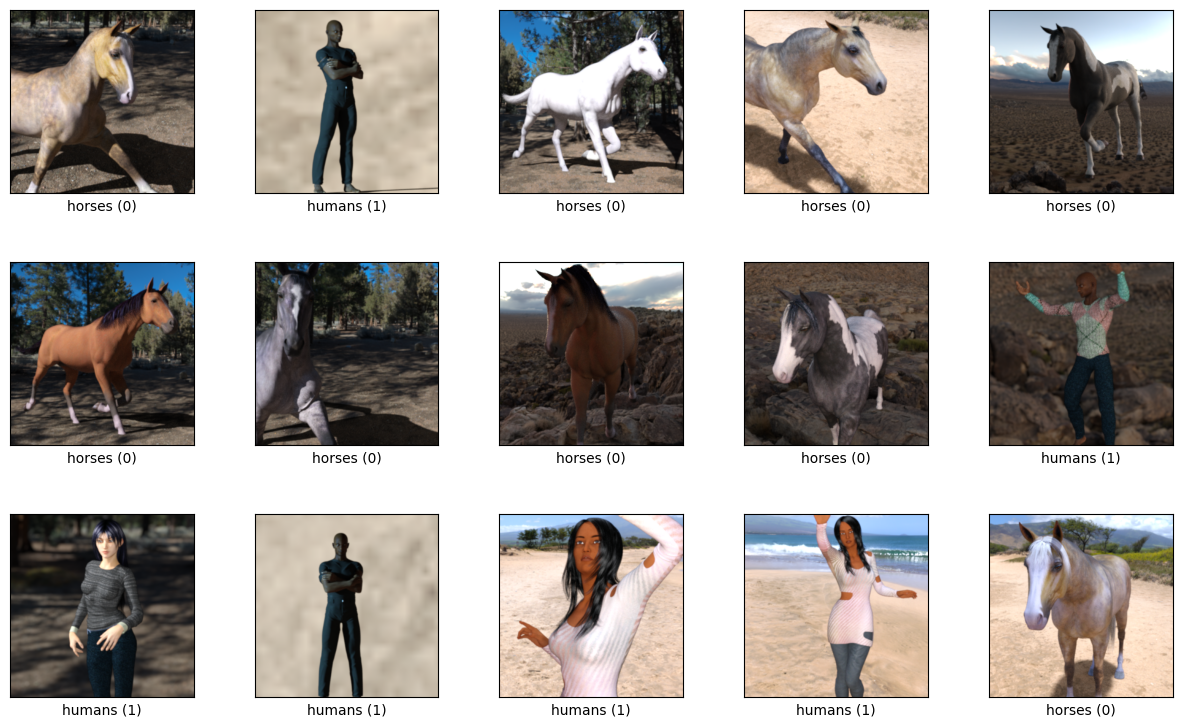

In [10]:
# train examples
tfds.show_examples(ds_train, ds_info, rows=3, cols=5);

2026-01-16 16:34:02.100068: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


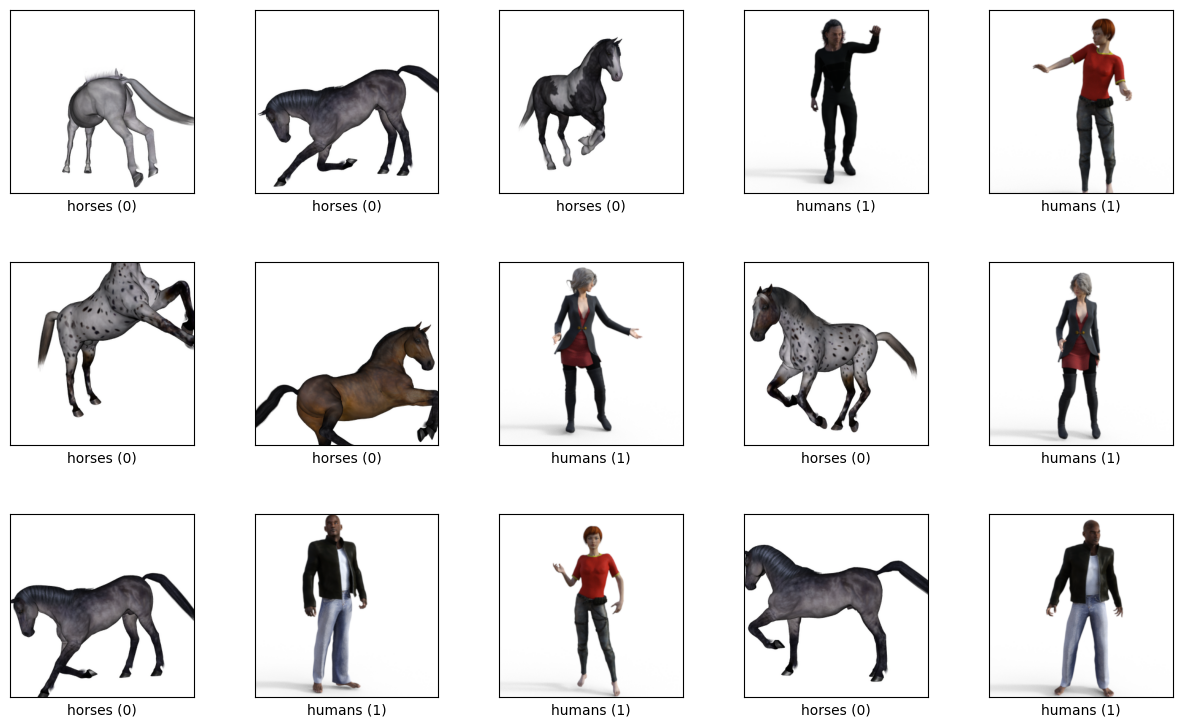

In [11]:
# test examples (do you see anything weird about the test examples?)
tfds.show_examples(ds_test, ds_info, rows=3, cols=5);

#### Batching

To get the benefits of <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>**stochastic gradient descent**</a> (SGD) during training, we'd like to feed elements from the dataset into our model in batches.

This is handled by the `batch()` method.

In [12]:
BATCH_SIZE = 32
num_batch = ds_train.cardinality() / BATCH_SIZE
print(f"Number of Potential Batches of size {BATCH_SIZE}:", num_batch.numpy())
num_batched_produced = ds_train.batch(BATCH_SIZE).cardinality()
print(f"Number of Batches of size {BATCH_SIZE} Produced:", num_batched_produced.numpy())

Number of Potential Batches of size 32: 32.09375
Number of Batches of size 32 Produced: 33


The batched dataset is itself a `Dataset`, but now it's an iterable that produces batches.

In a supervised learning situation like ours, each batch is a tuple.

In [13]:
# inspect first batch
my_batch = ds_train.batch(BATCH_SIZE).as_numpy_iterator().next()
print(f"Each batch is of type {type(my_batch)} with length {len(my_batch)}")

Each batch is of type <class 'tuple'> with length 2


The 1st element of the tuple are all the images in the batch.

In [14]:
# batch images
my_batch[0].shape

(32, 300, 300, 3)

The 2nd element are all the labels in the batch.

In [15]:
# batch labels
my_batch[1].shape

(32,)

#### Cache, Prefetch & Shuffle

There are helpful methods we can use to optimize the training process. Most of these descriptions are adapted from the TensorFlow documentation. As always, the documentation is the best place to go if you'd like a deeper understanding.

**<a href="https://www.tensorflow.org/guide/data_performance#caching">`Cache`</a>** caches a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch. (perhaps not a good idea for enormous datasets)

**`Prefetching`** overlaps the preprocessing and model execution of a training step. While the model is executing training steps, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data."

**<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle">`Shuffle`</a>** Randomly shuffles the elements of this dataset.

And we can chain all of these commands together...

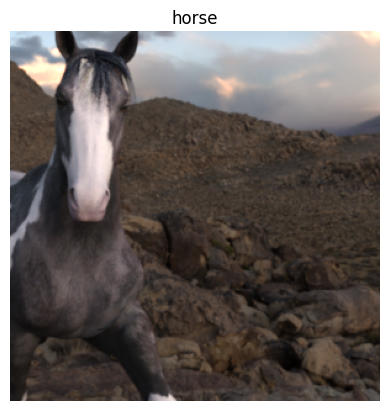

In [16]:
images, labels = (
    ds_train.cache()
    .shuffle(
        buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
    .as_numpy_iterator()
    .next()
)  # one batch

# show first image in batch
plt.imshow(images[0])
plt.title(class_names[labels[0]])
plt.axis("off")
plt.show()

#### Preprocessing with Datasets

Often, we'll want to **preprocess** our data in some way before feeding it into our model.<br>
We can use use the `Dataset` object's `map` method to perform arbitrary functions on the elements of the dataset.

Because the result of the `map` operation is itself a dataset object, we can continue to chain these commands one after another.<br>
Here we are normalizing and resizing our images as part of the preprocessing stage using functions of our own design. 

In [17]:
H = W = 200


def normalize_img(img, label):
    return tf.cast(img, tf.float32) / 255.0, label


def resize_img(img, label):
    return tf.image.resize(img, size=[H, W]), label


ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE).map(
    resize_img, AUTOTUNE
)
ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE).map(
    resize_img, AUTOTUNE
)

#### Data Augmentation


We almost always wish we had more data. But it can be expensive and time consuming to gather and label new data.

So why not simulate new data? We can accomplish this by creating variants of our original data. 

In the case of images this is very intuitive. Simply rotate your picture of a horse. It's still a horse, but the rotated image is likely different from anything in your data original. As long as the simulated data is not *too* different from the sort of example's we'd like to learn, this can help our model generalize better to previously unseen examples not in the original dataset.

In [18]:
def random_zoom(image, label):
    """Dataset pipe that zooms an image, helper function to augment below"""
    rand_float = tf.random.uniform([], 10, 20)
    rand_int = tf.cast(rand_float, tf.int32)
    image = tf.image.resize_with_crop_or_pad(
        image, H + H // rand_int, W + W // rand_int
    )
    image = tf.image.random_crop(image, size=[H, W, 3])
    return image, label


def augment(image, label):
    """Function that randomly alters an image with
    flipping, rotation, zoom, and contrast adjustment"""
    image = tf.image.random_flip_left_right(image)
    image, label = random_zoom(image, label)
    image = tf.image.random_contrast(image, lower=0.95, upper=1.0)
    return image, label

Here are just a few examples created using the augmentation functions defined above

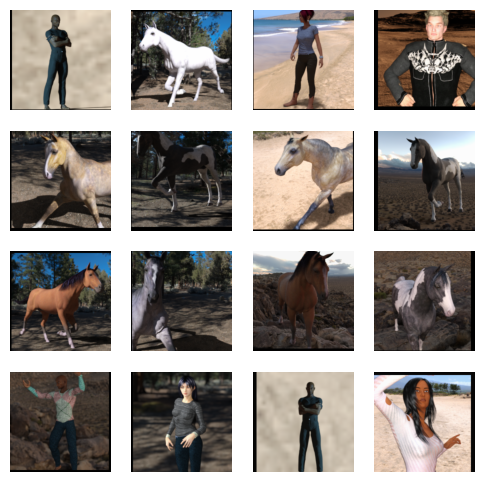

In [19]:
# display a batch of altered images
fig, axs = plt.subplots(4, 4, figsize=(6, 6))
aug_batch = ds_train.map(augment, num_parallel_calls=AUTOTUNE).take(16)
for ax, (img, label) in zip(axs.ravel(), aug_batch):
    ax.imshow(img)
    ax.axis("off")

## Keras

I'm sure you can appreciate implementing a CNN by hand would be a pain. We will be using <a href='https://keras.io/'>Keras</a> to quickly construct our neural networks.

The Keras API sits on top of Tensorflow. It allows the user to work at a more intuitive level of abstraction where the basic objects are **layers**.

<div id="keras_layers"><b>Layers of a CNN in Keras</b></div></br>
<img src='figs/cnn1.png', width='900px'>

#### Defining a Model

Here our task is building a CNN to classify images as either horses are humans.

We will begin with a very simply CNN. It should consist of the following layers:
- **Input** /w input shape derived below
- **Conv2D** /w 32 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 3x3
- **Conv2D** /w 64 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 3x3
- **Conv2D** /w 128 filters, 3x3 kernals, default padding & stride, and relu activation
- **MaxPool2D** of size 2x2
- **Flatten**
- **Dense** /w 64 units and relu activation
- **Dense** /w 1 unit and sigmoid for an activation

We'll need to specify an input shape for our model. We can derive this by looking at one of the images in our dataset.

In [20]:
# Find input shape
for element in ds_train.take(1).as_numpy_iterator():
    image_shape = element[0].shape
    print(f"The input shape of each batch is: {BATCH_SIZE}")
    print(f"The input shape of each image is: {image_shape}")

The input shape of each batch is: 32
The input shape of each image is: (200, 200, 3)


In [21]:
# Construct a CNN
inputs = Input(image_shape)
x = Conv2D(32, 3, padding="valid", activation="relu")(inputs)
x = MaxPool2D((3, 3))(x)
x = Conv2D(64, 3, padding="valid", activation="relu")(x)
x = MaxPool2D((3, 3))(x)
x = Conv2D(128, 3, padding="valid", activation="relu")(x)
x = MaxPool2D((3, 3))(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=inputs, outputs=outputs, name="Model1")

Now let's inspect the model with the `summary()` method. Notice how the dimensions change as the image passes through different stages of the network. Also take note of which layers have the most parameters.

In [22]:
model1.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 66, 66, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 128)       73856

**Compiling the Model**

Before we can train our model Keras requires use its `compile()` method to specify a few things:
- An [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) which controls how weights are updated
- A [loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses) which your model is trying to minimize
- A list of [metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) (optional) which are other functions that can be monitored during training

The compile method accepts optimizers, losses, and elements of the metrics list as either as objects from their respective Keras modules (imported below) or their names as strings (with underscores replacing spaces).

Compile your model with:
- `optimizer='SGD'`
- `meterics = ['acc']` (e.g., accuracy)
- `loss = `binary_crossentropy` (the loss function for binary classification)

In [23]:
# compile your model
model1.compile(optimizer="SGD", loss="binary_crossentropy", metrics=["acc"])

<div id="keras_train" class='exercise'><b>Train the Model</b></div></br>

Train your model by calling its `fit` method. We'll pass in our training data, validation data, and the number of epochs. Note the chaining of methods on the dataset objects.

In [24]:
history = model1.fit(
    ds_train.cache()
    .shuffle(
        buffer_size=ds_train.cardinality(), seed=SEED, reshuffle_each_iteration=True
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE),
    validation_data=ds_test.cache()
    .shuffle(
        buffer_size=ds_test.cardinality(), seed=SEED, reshuffle_each_iteration=True
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE),
    epochs=30,
)

Epoch 1/30
33/33 [==============================] - 9s 246ms/step - loss: 0.6908 - acc: 0.5686 - val_loss: 0.6864 - val_acc: 0.7500
Epoch 2/30
33/33 [==============================] - 8s 241ms/step - loss: 0.6864 - acc: 0.7215 - val_loss: 0.6862 - val_acc: 0.5000
Epoch 3/30
33/33 [==============================] - 8s 243ms/step - loss: 0.6830 - acc: 0.5482 - val_loss: 0.6766 - val_acc: 0.8164
Epoch 4/30
33/33 [==============================] - 7s 222ms/step - loss: 0.6789 - acc: 0.6991 - val_loss: 0.6724 - val_acc: 0.6094
Epoch 5/30
33/33 [==============================] - 8s 230ms/step - loss: 0.6736 - acc: 0.6913 - val_loss: 0.6639 - val_acc: 0.7812
Epoch 6/30
33/33 [==============================] - 7s 221ms/step - loss: 0.6678 - acc: 0.8092 - val_loss: 0.6604 - val_acc: 0.5625
Epoch 7/30
33/33 [==============================] - 7s 210ms/step - loss: 0.6599 - acc: 0.7605 - val_loss: 0.6488 - val_acc: 0.6367
Epoch 8/30
33/33 [==============================] - 7s 216ms/step - loss: 0.

<div class='exercise' id='plottinghistory'><b>Plot the Training History</b></div></br>

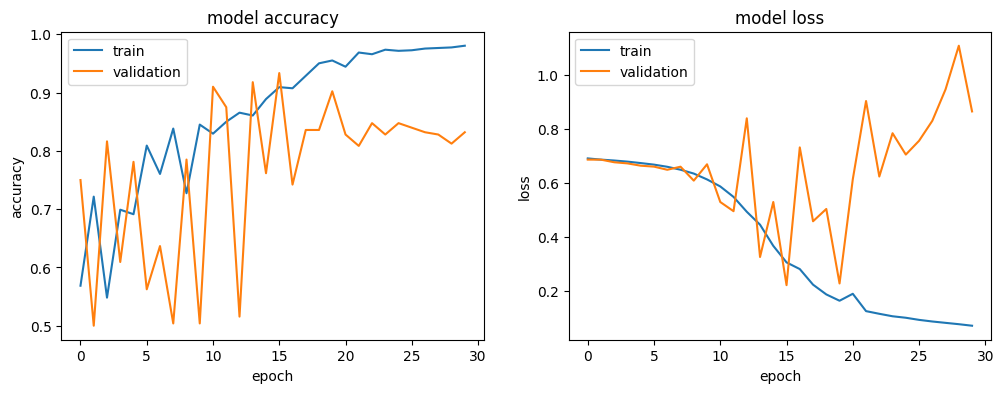

In [25]:
def plot_loss(model_history, out_file=None):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    history = model_history

    ax[0].plot(history.history["acc"])
    ax[0].plot(history.history["val_acc"])
    ax[0].set_title("model accuracy")
    ax[0].set_ylabel("accuracy")
    ax[0].set_xlabel("epoch")
    ax[0].legend(["train", "validation"], loc="upper left")

    ax[1].plot(history.history["loss"])
    ax[1].plot(history.history["val_loss"])
    ax[1].set_title("model loss")
    ax[1].set_ylabel("loss")
    ax[1].set_xlabel("epoch")
    ax[1].legend(["train", "validation"], loc="upper left")
    plt.show()

    if out_file:
        plt.savefig(out_file)


plot_loss(model_history=history)

#### Evaluate the Model

Let's see how we did using the model's `evaluate` method.

**Note:** Your model will complain if unless you passing it batches of the same size it saw during training.

In [26]:
model1.evaluate(ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE))

8/8 [==============================] - 1s 60ms/step - loss: 0.8645 - acc: 0.8320


[0.8644877672195435, 0.83203125]

In [27]:
model1.evaluate(ds_train.batch(BATCH_SIZE).prefetch(AUTOTUNE))

33/33 [==============================] - 3s 74ms/step - loss: 0.0674 - acc: 0.9844


[0.06739351898431778, 0.984420657157898]

#### Exercise: Improving on Baseline Model

Now see if you can improve on the performance of you previous model. You can try:
- adjusting the architecture
    - more/fewer layers/filters/units
    - adding a dropout(s) layer
- adding data augmentation
    - tweaking the various transformations included
- using callbacks like checkpointing or early stopping
- adjust the number of epochs
- adjust the batch size